<a href="https://colab.research.google.com/github/skywalker0803r/pa_0510/blob/V3/notebook/lstsq_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

df_path = '/content/drive/MyDrive/南亞PA廠/cleaned_data/train_cleaned.csv'
tag_path = '/content/drive/MyDrive/南亞PA廠/cleaned_data/tag_cleaned.csv'
df = pd.read_csv(df_path,index_col=0)
tag = pd.read_csv(tag_path,index_col=0)
tag.head()

,item,TAG,chinese,character,unit,category,period,min,max,推測顯著性(依製程經驗)
0,1.0,MLPAP_TJC-0627.PV,OX預熱器出口溫度,溫度,℃,可控制因子,1分鐘2筆,145,160,***
1,2.0,MLPAP_TRC-0610.PV,空氣預熱器出口溫度,溫度,℃,可控制因子,1分鐘2筆,160,200,***
2,3.0,MLPAP_FR-0632.PV,汽機風量,流量,KNM3/HR,可控制因子,1分鐘2筆,64,85.4,****
3,4.0,MLPAP_FQ-0619.PV,OX入料量,流量,kg/HR,可控制因子,1分鐘2筆,2000,8000,****
4,5.0,MLPAP_TJC-0757A.PV,反應槽鹽浴溫度,溫度,℃,可控制因子,1分鐘2筆,345,365,****


# INPUT

In [2]:
tag[tag.TAG.str.contains('0619.PV')]

,item,TAG,chinese,character,unit,category,period,min,max,推測顯著性(依製程經驗)
3,4.0,MLPAP_FQ-0619.PV,OX入料量,流量,kg/HR,可控制因子,1分鐘2筆,2000,8000,****


# OUTPUT

In [3]:
tag[tag.TAG.str.contains('0997.PV')]

,item,TAG,chinese,character,unit,category,period,min,max,推測顯著性(依製程經驗)
25,26.0,MLPAP_FQI-0997.PV,粗PA出料量,流量,KG/HR,不可控制因子,1分鐘2筆,2000,8800,***


# columns

In [4]:
x_col = tag[tag.TAG.str.contains('0619.PV')].TAG.tolist()
y_col = tag[tag.TAG.str.contains('0997.PV')].TAG.tolist()
x_col,y_col

(['MLPAP_FQ-0619.PV'], ['MLPAP_FQI-0997.PV'])

# visualization

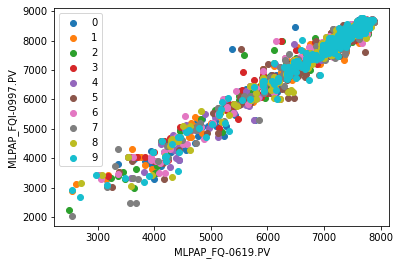

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

for i in range(10):
  d = df.sample(1000,random_state=i)
  plt.scatter(d[x_col[0]].values,d[y_col[0]].values,label=str(i))
plt.xlabel(x_col[0])
plt.ylabel(y_col[0])
plt.legend()
plt.show()

In [6]:
from numpy.linalg import inv
from tqdm import tqdm_notebook as tqdm
w_list = []
b_list = []
for i in tqdm(range(1000)):
  d = df[x_col+y_col].dropna(axis=0).sample(1000,random_state=i)
  A = d[x_col]
  A['bias'] = 1
  A = A.values
  b = d[y_col].values
  w = inv(A.T@A)@A.T@b
  w_list.extend(w[0])
  b_list.extend(w[1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


1.1575996945283165


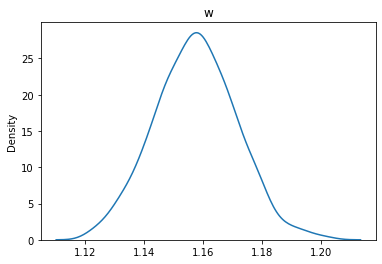

In [7]:
sns.kdeplot(w_list)
wm = np.mean(w_list)
plt.title('w')
print(wm)

-416.47623385366427


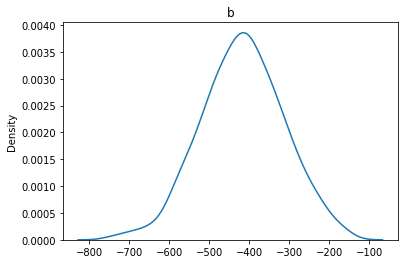

In [8]:
sns.kdeplot(b_list)
bm = np.mean(b_list)
plt.title('b')
print(bm)

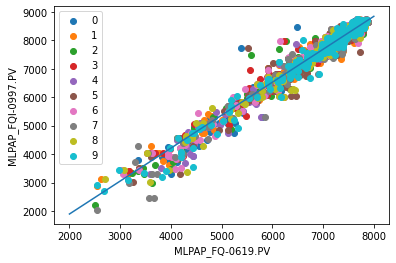

In [9]:
x = np.linspace(2000,8000,1000)
y = x*wm+bm
plt.plot(x,y)
for i in range(10):
  d = df.sample(1000,random_state=i)
  plt.scatter(d[x_col[0]].values,d[y_col[0]].values,label=str(i))
plt.xlabel(x_col[0])
plt.ylabel(y_col[0])
plt.legend()
plt.show()

# class F

In [10]:
class F(object):
  def __init__(self,w,b):
    self.w = w
    self.b = b
  def __call__(self,x):
    return x*self.w+self.b

f = F(wm,bm)
d = df[x_col+y_col].dropna(axis=0).sample(1000)
x = d[x_col[0]].values
y = d[y_col[0]].values
y_hat = f(x)

from sklearn.metrics import r2_score
r2_score(y,y_hat)

0.9715730749416484

# optimization Unit_consumption

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


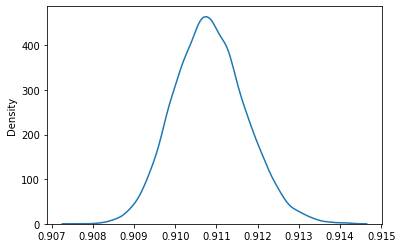

In [20]:
#Unit_consumption
uc_lst = []
d = df[x_col+y_col].dropna(axis=0)
for i in tqdm(range(10000)):
  s = d.sample(1000,random_state=i)
  uc = np.mean(s[x_col[0]].values/s[y_col[0]].values)
  uc_lst.append(uc)
sns.kdeplot(uc_lst)

In [23]:
uc_criteria = np.mean(uc_lst).round(4)
uc_criteria

0.9108

In [24]:
df['Unit_consumption'] = df[x_col[0]].values/df[y_col[0]].values
df[['Unit_consumption']].sample(5)

,Unit_consumption
2019-05-24 15:50:00,NaN
2017-09-16 20:50:00,0.910053
2020-07-15 08:40:00,0.908388
2020-06-29 04:30:00,0.937214
2018-04-12 03:00:00,NaN


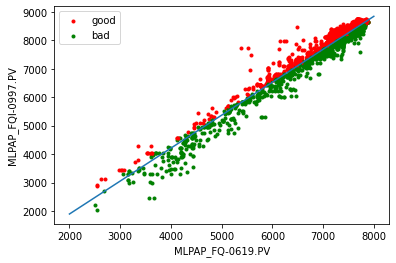

In [55]:
x = np.linspace(2000,8000,1000)
y = x*wm+bm
plt.plot(x,y)
for i in range(10):
  d = df.sample(1000,random_state=i)
  good = d[d['Unit_consumption'] < uc_criteria]
  bad = d[d['Unit_consumption'] > uc_criteria]
  if i == 0:
    plt.scatter(good[x_col[0]].values,good[y_col[0]].values,color='red',marker='.',label='good')
    plt.scatter(bad[x_col[0]].values,bad[y_col[0]].values,color='green',marker='.',label='bad')
  else:
    plt.scatter(good[x_col[0]].values,good[y_col[0]].values,color='red',marker='.')
    plt.scatter(bad[x_col[0]].values,bad[y_col[0]].values,color='green',marker='.')
plt.xlabel(x_col[0])
plt.ylabel(y_col[0])
plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


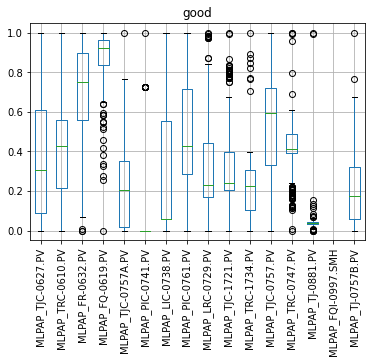

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


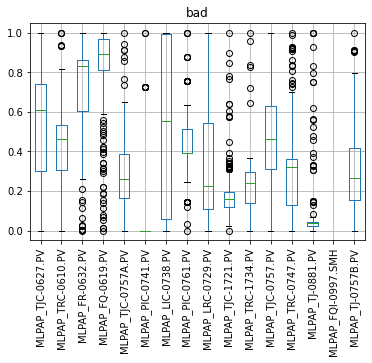

In [62]:
d = df.sample(1000)

good = d[d['Unit_consumption'] < uc_criteria]
bad = d[d['Unit_consumption'] > uc_criteria]

good = (good - good.min())/(good.max()-good.min())
bad = (bad - bad.min())/(bad.max()-bad.min())

good.boxplot(column=tag[tag.category=='可控制因子'].TAG.tolist(),rot=90)
plt.title('good')
plt.show()

bad.boxplot(column=tag[tag.category=='可控制因子'].TAG.tolist(),rot=90)
plt.title('bad')
plt.show()